Notebook getting exceedingly large, going forward, notebooks will be restricted to topics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
from scipy.integrate import cumulative_simpson as cumsimp
from scipy.linalg import cholesky, solve_triangular, solve

import dickandballs as db

In [2]:
x2 = np.linspace(7.596e-02, 50, 50) # my number density, starting val is ending val of n crust
#x2 = np.logspace(np.log10(n_crust[-1]), np.log10(50) , 50) # logspace from final value of crust number density to 50, note logspace uses base10

x1 = np.array([1,40])
cs2_1 = (np.array([0.033545,1/3]))
f1 = -np.log(1/cs2_1 - 1)

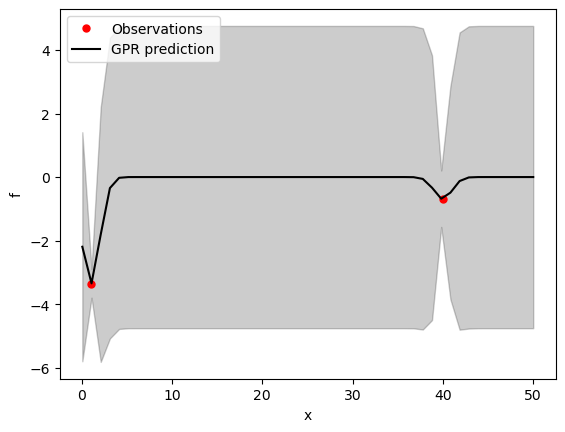

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(x1.reshape(-1, 1), f1.reshape(-1, 1))

f2, sigma = gpr.predict(x2.reshape(-1,1), return_std=True)

plt.figure()
plt.plot(x1, f1, 'r.', markersize=10, label='Observations')
plt.plot(x2, f2, '-', color='black', label='GPR prediction')
plt.fill_between(x2.ravel(), f2 - 1.96 * sigma, f2 + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

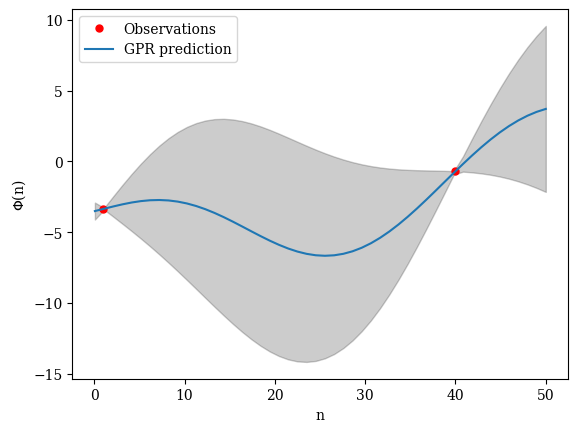

In [34]:
my_kernel = db.Kernel('SE', sigma=5, l=15)

my_gp = db.GP(my_kernel, -np.log(1/(0.72) - 1))

my_gp.fit(x1,x2,f1)

n = 1
y, sig = my_gp.posterior(n) # y is the phi


plt.figure()
plt.plot(x1, f1, 'r.', markersize=10, label='Observations')
for i in range(n):
    plt.plot(x2, y[i], label=f'GPR prediction' if i == 0 else "")
 
plt.fill_between(x2.ravel(), y[0] - 1.96 * sig, y[0] + 1.96 * sig, alpha=0.2, color='k')

plt.rcParams["font.family"] = "serif"
plt.xlabel('n')
plt.ylabel(r'$\Phi$(n)')
plt.legend()
plt.show()

# crust + eos properties

In [20]:
crust_eos= np.loadtxt('EOS/crust/crust_eos.dat')
n_crust, e_crust, p_crust, cs2_crust = crust_eos.T # unpacking the data into separate arrays

In [21]:
n_crust

array([2.720e-14, 1.270e-13, 6.930e-13, 6.295e-12, 1.581e-11, 3.972e-11,
       9.976e-11, 2.506e-10, 6.294e-10, 1.581e-09, 3.972e-09, 5.000e-09,
       9.976e-09, 1.990e-08, 3.973e-08, 7.926e-08, 1.581e-07, 1.991e-07,
       3.156e-07, 5.001e-07, 6.296e-07, 9.667e-07, 1.532e-06, 2.507e-06,
       3.974e-06, 4.830e-06, 6.081e-06, 7.930e-06, 9.982e-06, 1.257e-05,
       1.522e-05, 1.991e-05, 2.507e-05, 2.791e-05, 3.807e-05, 5.063e-05,
       6.592e-05, 8.433e-05, 1.062e-04, 1.321e-04, 1.624e-04, 1.690e-04,
       1.759e-04, 1.830e-04, 1.902e-04, 1.977e-04, 2.054e-04, 2.079e-04,
       2.082e-04, 2.091e-04, 2.160e-04, 2.231e-04, 2.311e-04, 2.401e-04,
       2.500e-04, 2.643e-04, 3.053e-04, 3.533e-04, 4.076e-04, 4.680e-04,
       5.341e-04, 6.059e-04, 7.661e-04, 1.262e-03, 1.895e-03, 2.673e-03,
       3.606e-03, 4.710e-03, 7.496e-03, 1.120e-02, 1.600e-02, 2.207e-02,
       2.948e-02, 4.268e-02, 6.220e-02, 7.317e-02, 7.596e-02])

In [22]:
epsi_ini = e_crust[-1]
p_ini = p_crust[-1]
n_ini = n_crust[-1]
mu_ini = (epsi_ini + p_ini) / n_ini
mu_crust_0 = (e_crust[0] + p_crust[0]) / n_crust[0]

### getting the properties

In [23]:
eos_props = db.EosProperties(x2, y.reshape(-1), epsi_ini, p_ini, mu_ini)
eos_prop_results = eos_props.get_all()

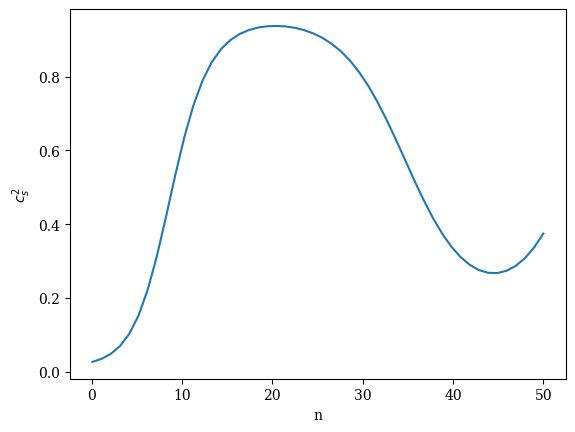

In [24]:
plt.plot(x2, eos_prop_results["cs2"])
plt.xlabel('n')
plt.ylabel(r'$c_s^2$')
plt.show()

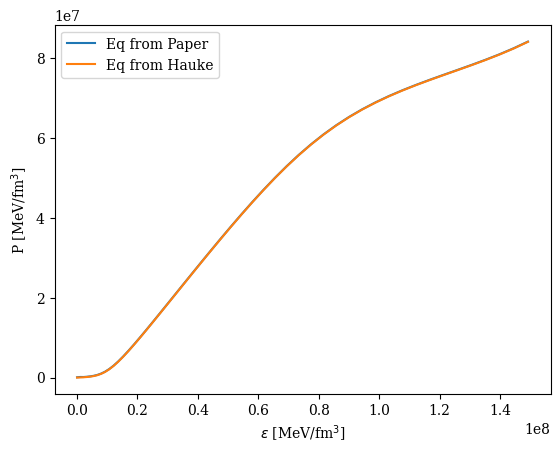

In [25]:
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure1"], label="Eq from Paper")
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure2"], label="Eq from Hauke")
plt.xlabel(r"$\epsilon$ [MeV/fm$^3$]")
plt.ylabel("P [MeV/fm$^3$]")
plt.legend()
plt.show()

In [26]:
eos_prop_results["pressure1"][:3]

array([ 68758.96188377, 150531.3697017 , 140093.1452744 ])

In [27]:
eos_prop_results["pressure2"][:3]

array([6.74250156e-01, 3.07637430e+04, 7.56739278e+04])

# hyperparemeter sampling

In [28]:
def get_hype_samples():
    
    rng = np.random.default_rng()
    cs2_hat = rng.normal(0.5,0.25**2)
    l = rng.normal(1, 0.25**2)
    nu = rng.normal(1.25, 0.2**2)

    return cs2_hat, l, nu

def get_phi(cs2):
    return -np.log(1/cs2 - 1)

In [29]:
x_test = np.linspace(7.596e-02, 50, 200) # my number density, starting val is ending val of n crust

x_train = np.array([1,40])
cs2_train = (np.array([0.033545,1/3]))
phi_train = get_phi(cs2_train)

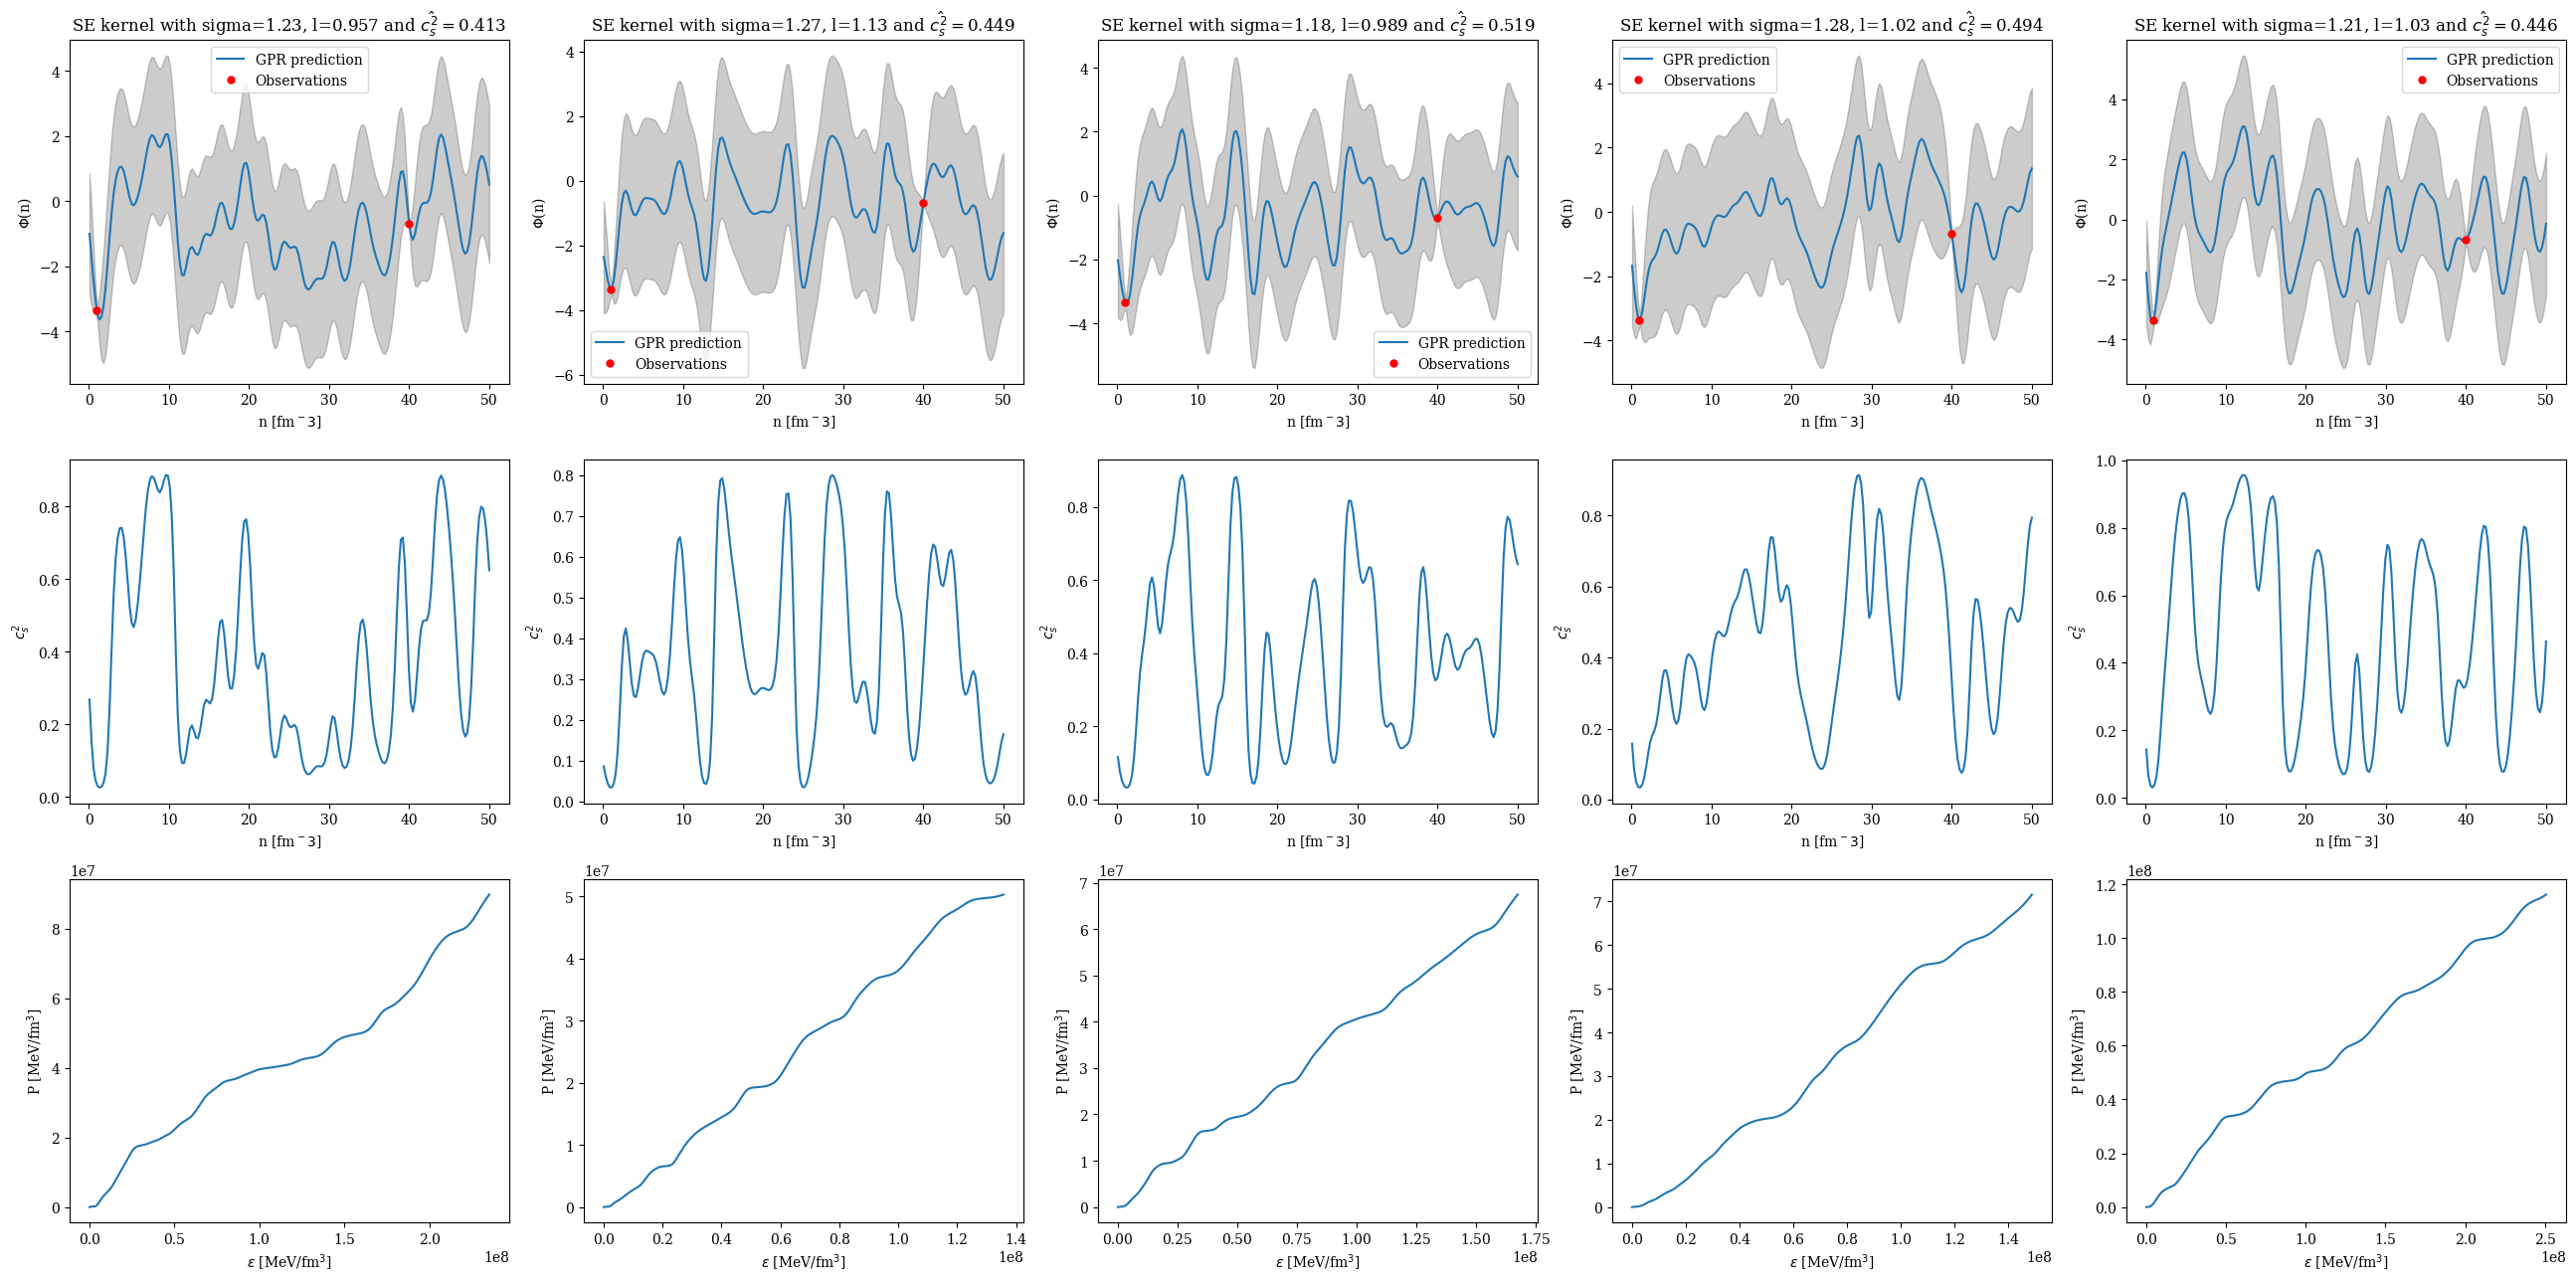

In [30]:
fig, axs = plt.subplots(3, 5, figsize=(26, 13))

for i in range(5):
    cs2_hat, l_hat, nu_hat = get_hype_samples()
    kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
    gp = db.GP(kernel, get_phi(cs2_hat))
    
    gp.fit(x_train,x_test,phi_train)

    phi_test, sig = gp.posterior()

    eos_props = db.EosProperties(x_test, phi_test.reshape(-1), epsi_ini, p_ini, mu_ini)
    eos_prop_results = eos_props.get_all()

    # Plot cs2 vs n in the top row
    axs[0, i].plot(x_test, phi_test[0], label=f'GPR prediction')
    axs[0, i].plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
    axs[0,i].fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
    axs[0, i].set_xlabel('n [fm$^-3$]')
    axs[0, i].set_ylabel(r'$\Phi$(n)')
    axs[0, i].legend()

    formatted_params = ', '.join([f'{key}={value:.3g}' for key, value in kernel.params.items()])
    title_str = f'{kernel.kernel_type} kernel with {formatted_params} and ' + r'$\hat{c_s^2}=$' + f'{cs2_hat:.3g}'
    axs[0, i].set_title(title_str)


    axs[1, i].plot(x_test, eos_prop_results['cs2'])
    axs[1, i].set_xlabel('n [fm$^-3$]')
    axs[1, i].set_ylabel(r'$c_s^2$')

    # Plot epsi vs p in the bottom row
    axs[2, i].plot(eos_prop_results['epsilon'], eos_prop_results['pressure2'])
    axs[2, i].set_xlabel(r"$\epsilon$ [MeV/fm$^3$]")
    axs[2, i].set_ylabel('P [MeV/fm$^3$]')

plt.rcParams["font.family"] = "serif"
plt.tight_layout()
plt.show()

# the chiral EFT:

Y = (upper + lower)/2

and

upper-lower = 75% credible interval

In [31]:
ceft_lower= np.loadtxt('EOS/ceft/eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt('EOS/ceft/eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T


In [32]:
n_ceft_avg = (n_ceft_upper+n_ceft_lower)/2
p_ceft_avg = (p_ceft_upper+p_ceft_lower)/2
e_ceft_avg = (e_ceft_upper+e_ceft_lower)/2

cs2_ceft_avg = np.gradient(p_ceft_avg, e_ceft_avg) #dp/de

In [33]:
p_ceft_width = p_ceft_upper-p_ceft_lower
e_ceft_width = e_ceft_upper-e_ceft_lower



Dcs2Dp_ceft_avg = np.gradient(cs2_ceft_avg, p_ceft_avg) # d(cs2)/dp
Dcs2De_ceft_avg = np.gradient(cs2_ceft_avg, e_ceft_avg) # d(cs2)/de

e_ceft_sigma = CI_to_sigma(e_ceft_width)
p_ceft_sigma = CI_to_sigma(p_ceft_width)

cs2_ceft_sigma = ((Dcs2Dp_ceft_avg*p_ceft_sigma)**0.5 + (Dcs2De_ceft_avg*e_ceft_sigma)**0.5)**0.5
cs2_ceft_width = 2*1.15*cs2_ceft_sigma
cs2_ceft_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_ceft_upper = np.gradient(p_ceft_upper, e_ceft_upper) #dp/de
cs2_ceft_crude_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_crude_sigma = CI_to_sigma(cs2_ceft_crude_width)

NameError: name 'CI_to_sigma' is not defined

In [35]:
plt.plot(n_ceft_avg, cs2_ceft, label='Average')

plt.plot(n_ceft_avg, cs2_ceft_lower, '--', color='orange')
plt.plot(n_ceft_avg, cs2_ceft_upper, '--', color='orange', label='Soft/Stiff')

plt.plot(n_ceft_avg, cs2_ceft_avg+cs2_ceft_crude_width/2, color='red', label='Substracted Lower/Upper CI')
plt.plot(n_ceft_avg, cs2_ceft_avg-cs2_ceft_crude_width/2, color='red')

plt.plot(n_ceft_avg, cs2_ceft_avg+cs2_ceft_width/2, color='green', label='Error Propogated Lower/Upper CI')
plt.plot(n_ceft_avg, cs2_ceft_avg-cs2_ceft_width/2, color='green')

plt.ylabel('Sound Speed')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


NameError: name 'cs2_ceft' is not defined

### gpr from crust to n=50

still have the weird shape

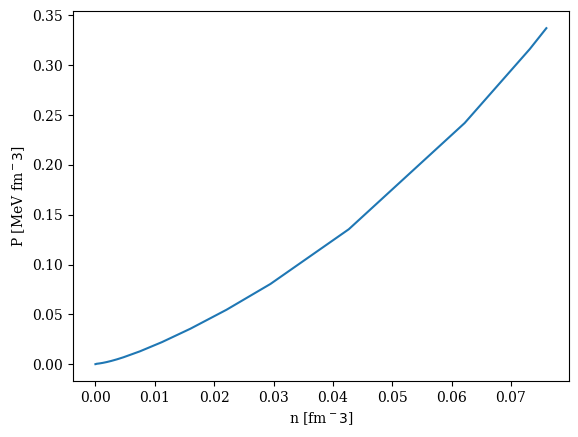

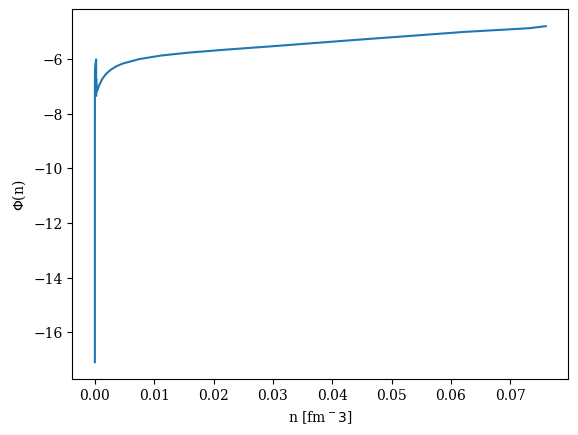

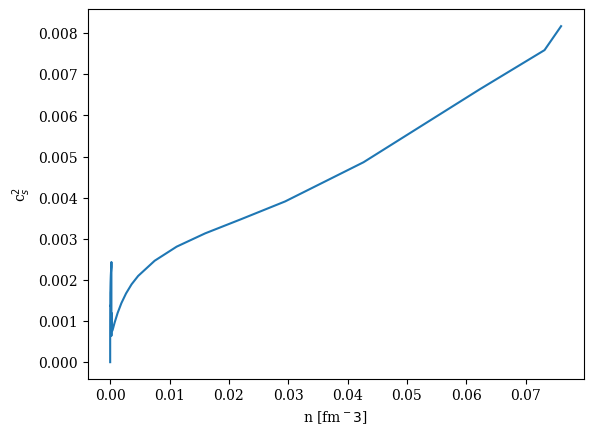

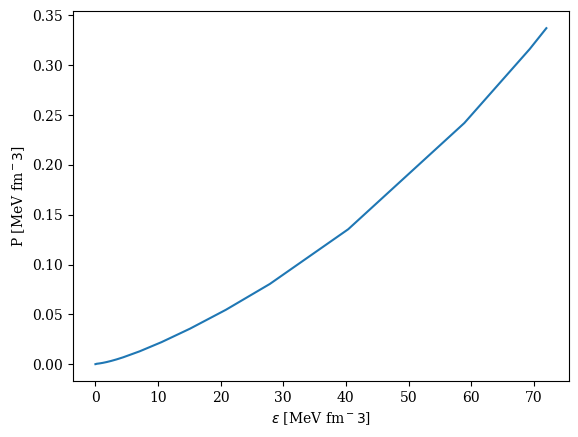

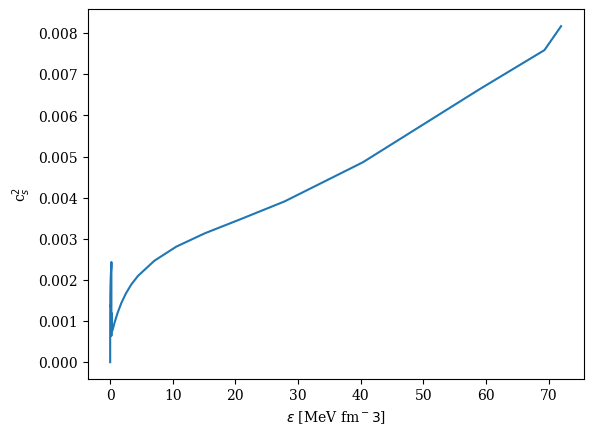

In [36]:
plt.plot(n_crust, p_crust)
plt.xlabel(r'n [fm$^-3$]')
plt.ylabel(r'P [MeV fm$^-3$]')
plt.show()

plt.plot(n_crust, get_phi(cs2_crust))
plt.xlabel(r'n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.show()


plt.plot(n_crust, cs2_crust)
plt.xlabel(r'n [fm$^-3$]')
plt.ylabel(r'c$_s^2$')
plt.show()


plt.plot(e_crust, p_crust)
plt.xlabel(r'$\epsilon$ [MeV fm$^-3$]')
plt.ylabel(r'P [MeV fm$^-3$]')
plt.show()

plt.plot(e_crust, cs2_crust)
plt.xlabel(r'$\epsilon$ [MeV fm$^-3$]')
plt.ylabel(r'c$_s^2$')
plt.show()



/home/sam/thesis/thesiscode/dickandballs.py:231: RuntimeWarning: overflow encountered in exp
  self.mu = np.exp(log_mu)
/home/sam/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:760: RuntimeWarning: invalid value encountered in add
  return x21/6 * (coeff1*f1 + coeff2*f2 + coeff3*f3)


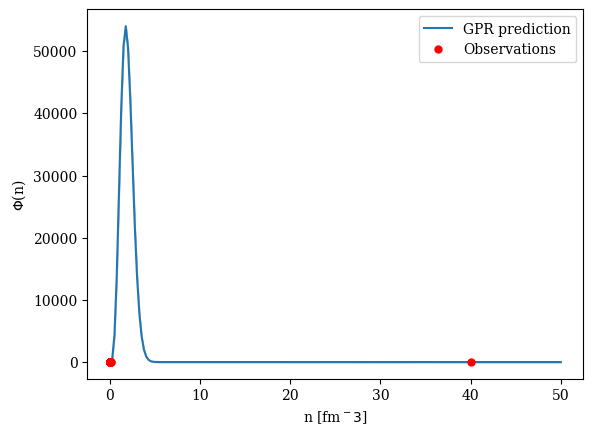

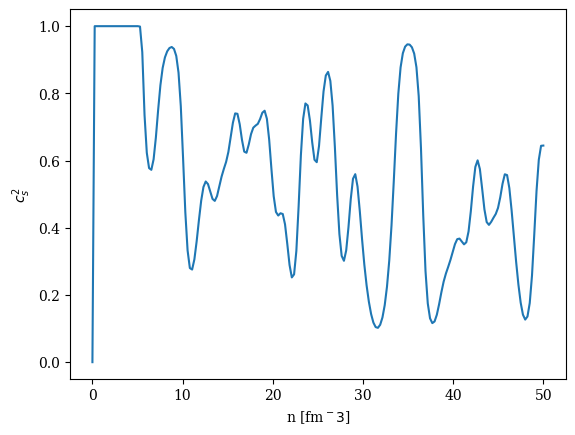

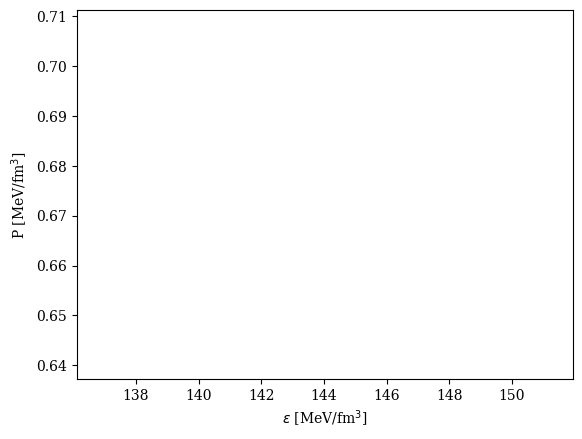

In [37]:
x_test = np.linspace(n_crust[0], 50, 200) # my number density, starting val is ending val of n crust

x_train = np.append(n_crust, 40)
cs2_train = np.append(cs2_crust, 1/3)
phi_train = get_phi(cs2_train)

cs2_hat, l_hat, nu_hat = get_hype_samples()
kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
gp = db.GP(kernel, get_phi(cs2_hat))

gp.fit(x_train,x_test,phi_train, stabilise=True)

phi_test, sig = gp.posterior()

eos_props = db.EosProperties(x_test, phi_test.reshape(-1), epsi_ini, p_ini, mu_ini)
eos_prop_results = eos_props.get_all()

plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.legend()

formatted_params = ', '.join([f'{key}={value:.3g}' for key, value in kernel.params.items()])
title_str = f'{kernel.kernel_type} kernel with {formatted_params} and ' + r'$\hat{c_s^2}=$' + f'{cs2_hat:.3g}'
plt.show()


plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$c_s^2$')
plt.show()

plt.plot(eos_prop_results['epsilon'], eos_prop_results['pressure2'])
plt.xlabel(r"$\epsilon$ [MeV/fm$^3$]")
plt.ylabel('P [MeV/fm$^3$]')
plt.show()



### gpr from n_ceft to n=50

ceft includes crust i think

have the weird shape

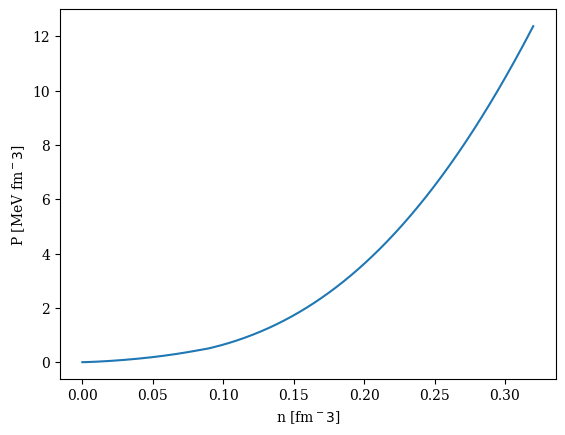

NameError: name 'cs2_ceft' is not defined

In [38]:
plt.plot(n_ceft_avg, p_ceft_avg)
plt.xlabel(r'n [fm$^-3$]')
plt.ylabel(r'P [MeV fm$^-3$]')
plt.show()

plt.plot(n_ceft_avg, get_phi(cs2_ceft))
plt.xlabel(r'n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.show()


plt.plot(n_ceft_avg, cs2_ceft)
plt.xlabel(r'n [fm$^-3$]')
plt.ylabel(r'c$_s^2$')
plt.show()


plt.plot(e_ceft_avg, p_ceft_avg)
plt.xlabel(r'$\epsilon$ [MeV fm$^-3$]')
plt.ylabel(r'P [MeV fm$^-3$]')
plt.show()

plt.plot(e_ceft_avg, cs2_ceft)
plt.xlabel(r'$\epsilon$ [MeV fm$^-3$]')
plt.ylabel(r'c$_s^2$')
plt.show()



In [39]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

x_test = np.linspace(n_ceft_avg[0], n_ceft_avg[-1], 200)

#x_train = np.append(n_ceft_avg, 40)
#cs2_train = np.append(cs2_ceft, 1/3)

x_train = n_ceft_avg
cs2_train = cs2_ceft

phi_train = get_phi(cs2_train)

# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2,1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(x_train.reshape(-1, 1), phi_train.reshape(-1, 1))

phi_test, sigma = gpr.predict(x_test.reshape(-1,1), return_std=True)

plt.figure()
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.plot(x_test, phi_test, '-', color='black', label='GPR prediction')
plt.fill_between(x_test.ravel(), phi_test - 1.96 * sigma, phi_test + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.ylabel('f')
plt.legend()
plt.show()

NameError: name 'cs2_ceft' is not defined

In [22]:
x_test = np.linspace(n_ceft_avg[0], n_ceft_avg[-1], 200)

#x_train = np.append(n_ceft_avg, 40)
#cs2_train = np.append(cs2_ceft, 1/3)

x_train = n_ceft_avg
cs2_train = cs2_ceft

phi_train = get_phi(cs2_train)

/home/sam/thesis/thesiscode/dickandballs.py:219: RuntimeWarning: overflow encountered in exp
  self.mu = np.exp(log_mu)
/home/sam/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:760: RuntimeWarning: invalid value encountered in add
  return x21/6 * (coeff1*f1 + coeff2*f2 + coeff3*f3)


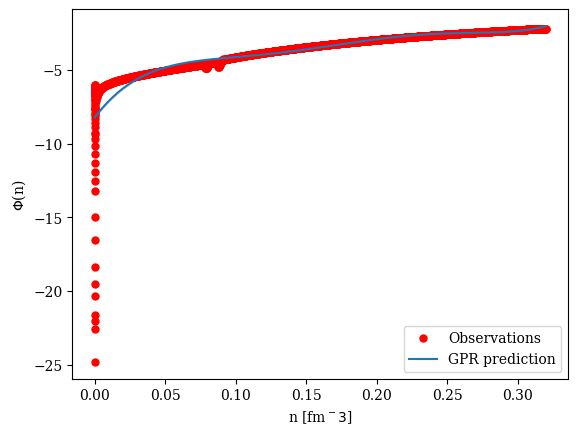

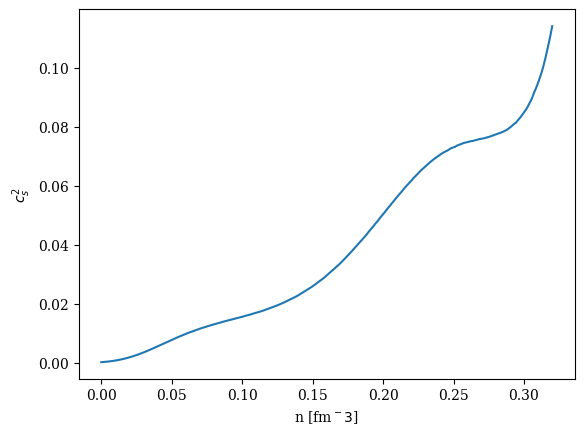

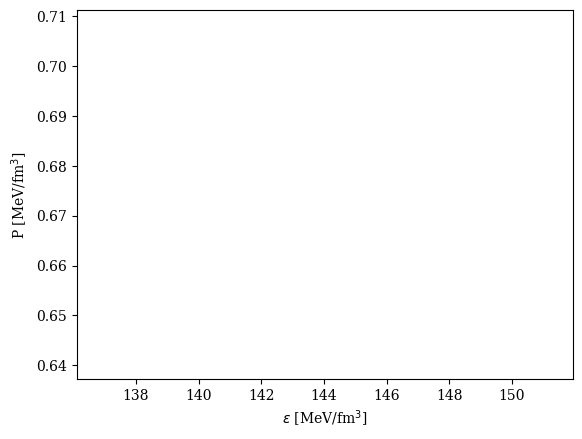

In [23]:
cs2_hat, l_hat, nu_hat = get_hype_samples()
kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
gp = db.GP(kernel, get_phi(cs2_hat))

gp.fit(x_train,x_test,phi_train, stabilise=True)

phi_test, sig = gp.posterior()

eos_props = db.EosProperties(x_test, phi_test.reshape(-1), epsi_ini, p_ini, mu_ini)
eos_prop_results = eos_props.get_all()

plt.rcParams["font.family"] = "serif"

plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.legend()

formatted_params = ', '.join([f'{key}={value:.3g}' for key, value in kernel.params.items()])
title_str = f'{kernel.kernel_type} kernel with {formatted_params} and ' + r'$\hat{c_s^2}=$' + f'{cs2_hat:.3g}'
plt.show()


plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$c_s^2$')
plt.show()

plt.plot(eos_prop_results['epsilon'], eos_prop_results['pressure2'])
plt.xlabel(r"$\epsilon$ [MeV/fm$^3$]")
plt.ylabel('P [MeV/fm$^3$]')
plt.show()



### trying to reduce samples in ceft

use from 0.5nsat to 2nsat for n_ceft_avg

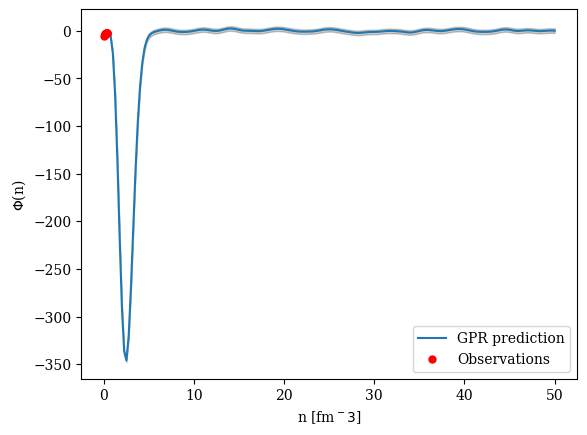

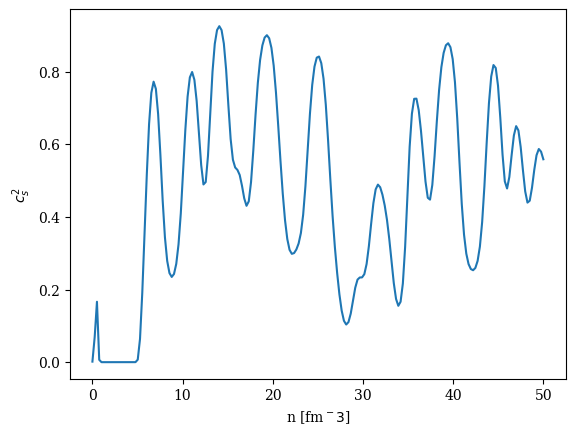

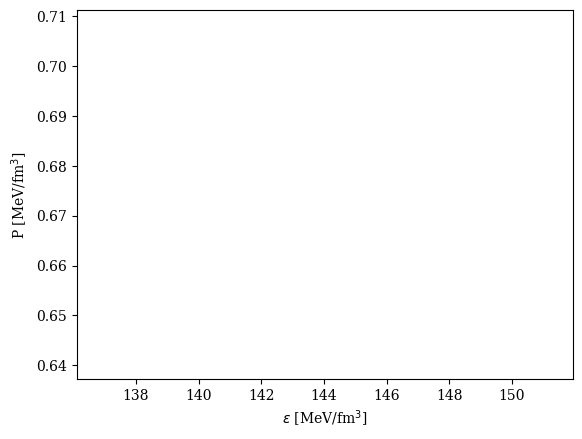

In [24]:
import random

x_test = np.linspace(n_ceft_avg[0], 50, 200) 

indices = random.sample(range(len(n_ceft_avg)), 10)
indices.sort()

x_train = n_ceft_avg[indices]
cs2_train = cs2_ceft[indices]
phi_train = get_phi(cs2_train)

cs2_hat, l_hat, nu_hat = get_hype_samples()
kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
gp = db.GP(kernel, get_phi(cs2_hat))

gp.fit(x_train,x_test,phi_train, stabilise=True)

phi_test, sig = gp.posterior()

eos_props = db.EosProperties(x_test, phi_test.reshape(-1), epsi_ini, p_ini, mu_ini)
eos_prop_results = eos_props.get_all()

plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.legend()

formatted_params = ', '.join([f'{key}={value:.3g}' for key, value in kernel.params.items()])
title_str = f'{kernel.kernel_type} kernel with {formatted_params} and ' + r'$\hat{c_s^2}=$' + f'{cs2_hat:.3g}'
plt.show()


plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$c_s^2$')
plt.show()

plt.plot(eos_prop_results['epsilon'], eos_prop_results['pressure2'])
plt.xlabel(r"$\epsilon$ [MeV/fm$^3$]")
plt.ylabel('P [MeV/fm$^3$]')
plt.show()



need to fix this, it shouldnt look so weird

# Hebeler CEFT

In [32]:
ceft_hebeler= np.loadtxt('EOS/ceft/ceft_hebeler.dat')
n_n0_hebeler, _, p_hebeler_lower, e_hebeler_lower, _,_,_,_,_,_,_,_, p_hebeler_upper, e_hebeler_upper, _, _, _ = ceft_hebeler.T

p_hebeler_avg = (p_hebeler_upper+p_hebeler_lower)/2
e_hebeler_avg = (e_hebeler_upper+e_hebeler_lower)/2

p_hebeler_width = p_hebeler_upper-p_hebeler_lower
e_hebeler_width = e_hebeler_upper-e_hebeler_lower

cs2_hebeler_avg = np.gradient(p_hebeler_avg, e_hebeler_avg) #dp/de


### uncertainty propagation

In [26]:
def CI_to_sigma(width):
    """From CI 75% to a sigma value
    z*sigma = width/2
    TODO: automate z score so any CI can be taken"""
    z = 1.15
    sig = width/(2*z)
    return(sig)

$c_s^2= \frac{dP}{d\epsilon}$

$\sigma_{c_s^2} = \sqrt{ (\frac{\partial (c_s^2)}{\partial P}\sigma_{P})^2 + (\frac{\partial (c_s^2)}{\partial \epsilon}\sigma_{\epsilon})^2}$

where $\sigma_P$ or $\sigma_{\epsilon}$ is gotten from:

$\text{HebelerHigh}-\text{HebelerLow} =  w$

We know this is the 75% credible interval. z=1.15... for this CI, [see 68-95-99 rule wikipedia and find z given alpha values]. then:

$$\sigma = \frac{w}{2z}$$

and inverse:

$$w = 2z\sigma$$


In [95]:
Dcs2Dp_hebeler_avg = np.gradient(cs2_hebeler_avg, p_hebeler_avg) # d(cs2)/dp
Dcs2De_hebeler_avg = np.gradient(cs2_hebeler_avg, e_hebeler_avg) # d(cs2)/de

e_hebeler_sigma = CI_to_sigma(e_hebeler_width)
p_hebeler_sigma = CI_to_sigma(p_hebeler_width)

cs2_hebeler_sigma_err_prop = ((Dcs2Dp_hebeler_avg*p_hebeler_sigma)**0.5 + (Dcs2De_hebeler_avg*e_hebeler_sigma)**0.5)**0.5
cs2_hebeler_CI =1.15*cs2_hebeler_sigma_err_prop

In [64]:
cs2_hebeler_lower = np.gradient(p_hebeler_lower, e_hebeler_lower) #dp/de
cs2_hebeler_upper = np.gradient(p_hebeler_upper, e_hebeler_upper) #dp/de
cs2_hebeler_avg_other = (cs2_hebeler_upper+cs2_hebeler_lower)/2
cs2_hebeler_crude_width = cs2_hebeler_upper-cs2_hebeler_lower
cs2_hebeler_crude_sigma = CI_to_sigma(cs2_hebeler_crude_width)

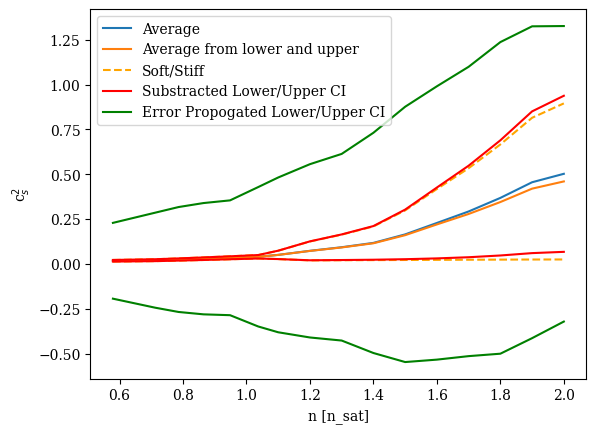

In [101]:
plt.plot(n_n0_hebeler, cs2_hebeler_avg, label='Average')
plt.plot(n_n0_hebeler, cs2_hebeler_avg_other, label='Average from lower and upper')


plt.plot(n_n0_hebeler, cs2_hebeler_lower, '--', color='orange')
plt.plot(n_n0_hebeler, cs2_hebeler_upper, '--', color='orange', label='Soft/Stiff')

plt.plot(n_n0_hebeler, cs2_hebeler_avg+cs2_hebeler_crude_width/2, color='red', label='Substracted Lower/Upper CI')
plt.plot(n_n0_hebeler, cs2_hebeler_avg-cs2_hebeler_crude_width/2, color='red')

plt.plot(n_n0_hebeler, cs2_hebeler_avg+cs2_hebeler_CI, color='green', label='Error Propogated Lower/Upper CI')
plt.plot(n_n0_hebeler, cs2_hebeler_avg-cs2_hebeler_CI, color='green')

plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



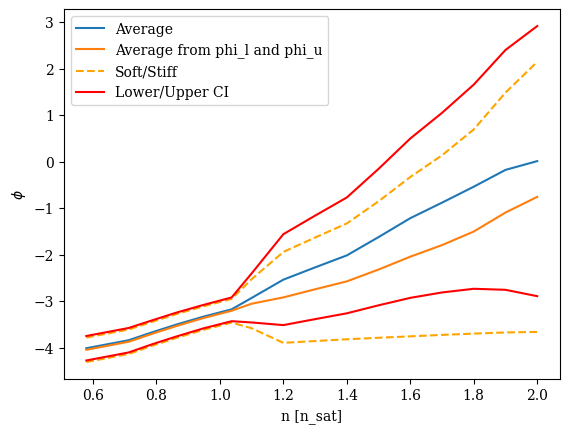

In [63]:
phi_hebeler_avg = get_phi(cs2_hebeler_avg)
phi_hebeler_lower = get_phi(cs2_hebeler_lower)
phi_hebeler_upper = get_phi(cs2_hebeler_upper)
phi_hebeler_width = phi_hebeler_upper-phi_hebeler_lower
phi_hebeler_avg_other = (phi_hebeler_upper+phi_hebeler_lower)/2


plt.plot(n_n0_hebeler, phi_hebeler_avg, label='Average')
plt.plot(n_n0_hebeler, phi_hebeler_avg_other, label='Average from phi_l and phi_u')
plt.plot(n_n0_hebeler, phi_hebeler_lower, '--', color='orange')
plt.plot(n_n0_hebeler, phi_hebeler_upper, '--', color='orange', label='Soft/Stiff')
plt.plot(n_n0_hebeler, phi_hebeler_avg+phi_hebeler_width/2, color='red', label='Lower/Upper CI')
plt.plot(n_n0_hebeler, phi_hebeler_avg-phi_hebeler_width/2, color='red')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


In [96]:
phi_hebeler_sigma = CI_to_sigma(phi_hebeler_width)

unsure whether to use $\frac{dP_{avg}}{d\epsilon_{avg}}$ as $(c_s^2)_{avg}$ (derivative of averages)

or $\frac{(c_s^2)_{upper}+(c_s^2)_{lower}}{2}$ as $(c_s^2)_{avg}$ (average of derivatives)

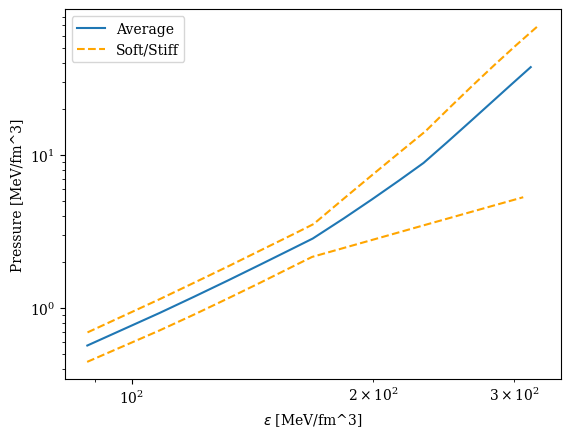

In [ ]:
plt.plot(e_hebeler_avg, p_hebeler_avg, label='Average')
plt.plot(e_hebeler_lower, p_hebeler_lower, '--', color='orange')
plt.plot(e_hebeler_upper, p_hebeler_upper, '--', color='orange', label='Soft/Stiff')
#plt.plot(e_hebeler_avg+e_hebeler_width/2, p_hebeler_avg+p_hebeler_width/2, color='red', label='Lower/Upper CI')
#plt.plot(e_hebeler_avg-e_hebeler_width/2, p_hebeler_avg-p_hebeler_width/2, color='red')
plt.ylabel('Pressure [MeV/fm^3]')
plt.xlabel(r'$\epsilon$ [MeV/fm^3]')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

# this looks like the hebeler paper fig 12 (truncated)

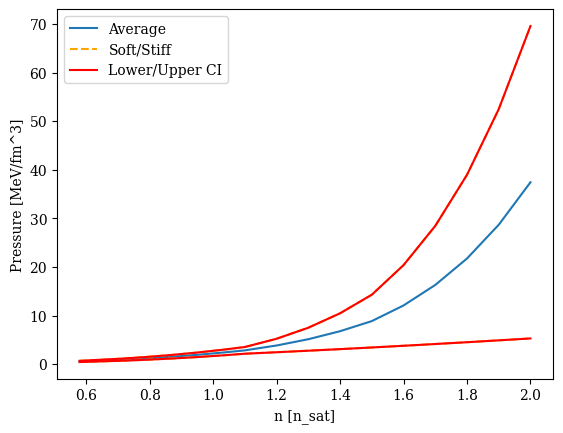

In [29]:
plt.plot(n_n0_hebeler, p_hebeler_avg, label='Average')
plt.plot(n_n0_hebeler, p_hebeler_lower, '--', color='orange')
plt.plot(n_n0_hebeler, p_hebeler_upper, '--', color='orange', label='Soft/Stiff')
plt.plot(n_n0_hebeler, p_hebeler_avg+p_hebeler_width/2, color='red', label='Lower/Upper CI')
plt.plot(n_n0_hebeler, p_hebeler_avg-p_hebeler_width/2, color='red')
plt.ylabel('Pressure [MeV/fm^3]')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



In [40]:
n_crust[-1]

0.07596

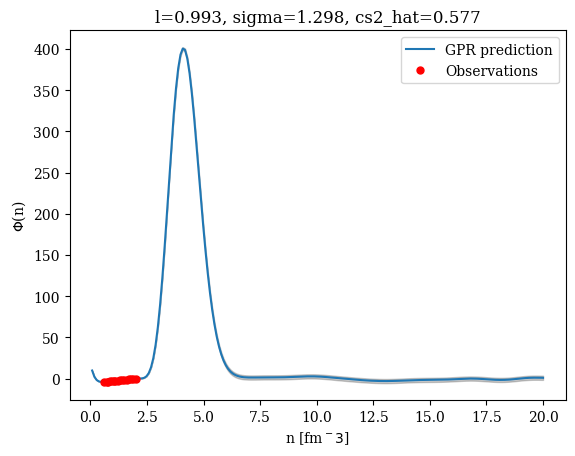

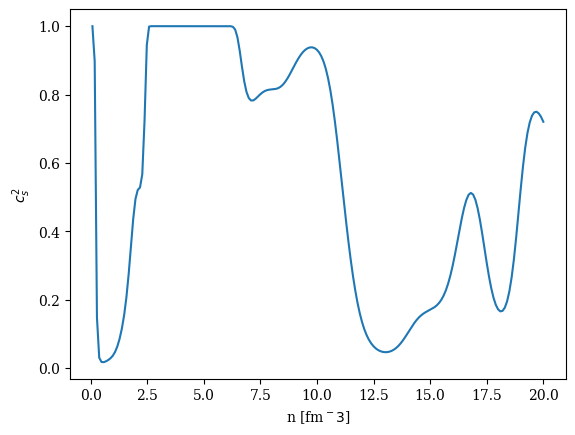

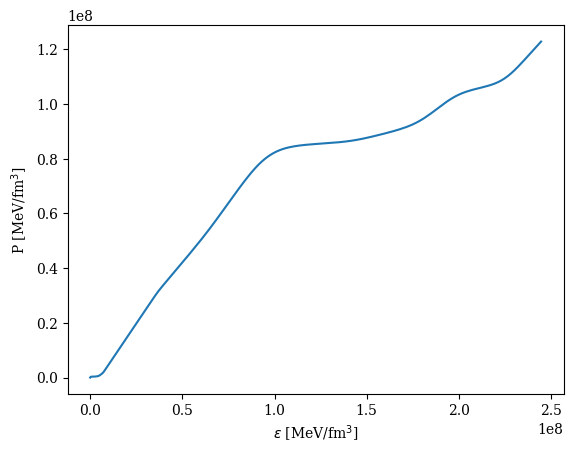

In [30]:
x_test = np.linspace(n_crust[-1], 20, 200) # my number density, starting val is ending val of n crust

#x_train = np.append(n_n0_hebeler, 40)
#cs2_train = np.append(cs2_hebeler_avg, 1/3)

x_train = n_n0_hebeler
cs2_train = cs2_hebeler_avg

phi_train = get_phi(cs2_train)

cs2_hat, l_hat, nu_hat = get_hype_samples()
kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)
gp = db.GP(kernel, get_phi(cs2_hat))

gp.fit(x_train, x_test, phi_train, stabilise=True)

phi_test, sig = gp.posterior()

eos_props = db.EosProperties(x_test, phi_test.reshape(-1), epsi_ini, p_ini, mu_ini)
eos_prop_results = eos_props.get_all()

plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}")
plt.legend()

formatted_params = ', '.join([f'{key}={value:.3g}' for key, value in kernel.params.items()])
title_str = f'{kernel.kernel_type} kernel with {formatted_params} and ' + r'$\hat{c_s^2}=$' + f'{cs2_hat:.3g}'
plt.show()


plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [fm$^-3$]')
plt.ylabel(r'$c_s^2$')
plt.show()

plt.plot(eos_prop_results['epsilon'], eos_prop_results['pressure2'])
plt.xlabel(r"$\epsilon$ [MeV/fm$^3$]")
plt.ylabel('P [MeV/fm$^3$]')
plt.show()



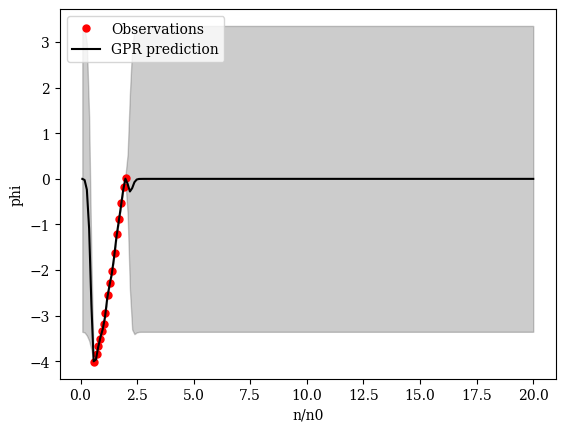

In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


# the squared exponential kernel is RBF kernel
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2,1e2))

gpr = GaussianProcessRegressor(kernel=kernel)
# fit the model to the residuals
gpr.fit(x_train.reshape(-1, 1), phi_train.reshape(-1, 1))

phi_test, sigma = gpr.predict(x_test.reshape(-1,1), return_std=True)

plt.figure()
plt.plot(x_train, phi_train, 'r.', markersize=10, label='Observations')
plt.plot(x_test, phi_test, '-', color='black', label='GPR prediction')
plt.fill_between(x_test.ravel(), phi_test - 1.96 * sigma, phi_test + 1.96 * sigma, alpha=0.2, color='k')
plt.xlabel('n/n0')
plt.ylabel('phi')
plt.legend()
plt.show()

# TODO

make eos properties take in variables supplied in addition to self, so that the same functions can be used for like get_phi and get mu init

and other kernels + white noise kernel, and add functionality to add and multiply kernels.

add student t process